<div style="text-align: center;">
    <img src="Logo/0.%20Logo.png" alt="Logo" style="width: 150px; height: auto;"> <br>
    <img src="Logo/0.%20Logo%20Name.png" alt="LogoName" style="width: 300px; height: auto;">
</div>

# Smart Device Usage Analysis

In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; } </style>"))

## Table of Contents <a id="back"></a>
* [Introduction](#intro)
* [Initial Data Exploration](#eda)
* [Calories Function](#calories)
* [Steps Function](#steps)
* [Sleep Function](#sleep)
* [Intensities Function](#intensities)
* [Conclusions](#conclusion)

## Introduction <a id="intro"></a>

Bellabeat is a high-tech manufacturer of health-focused products for women. Since its founding, Bellabeat has experienced rapid growth and has the potential to become a major player in the global smart device market. While our current marketing strategy primarily focuses on digital channels, we also invest on a smaller scale in traditional media.

The Chief Creative Officer believes that analyzing consumer data could reveal new growth opportunities. The Marketing Analytics Team has been tasked with analyzing smart device data to gain insights into how consumers use it. These insights will then be used to inform and refine future marketing strategies.
  <br>
  <br>

<div style="text-align: center;">
  <div style="display: inline-block; border: 1px solid; padding: 10px;">
    <strong><em>Business Task:</em></strong><br>
    <em>Analyze smart device usage data to understand consumer behavior, uncover opportunities for growth, and guide marketing strategies.</em>
  </div>
</div>

  <br>
  <br>
For this analysis, we are using publicly available data from Fitbit Fitness Trackers. The dataset includes daily metrics (such as steps, distance, activity intensities, calories burned, and sleep time) as well as hourly data (calories burned, heart rate, and steps), spanning from April 11, 2016, to May 12, 2016. The complete dataset contains 18 CSV files, of which 7 were utilized in this analysis.

## Initial Data Exploration <a id="eda"></a>

In [2]:
import pandas as pd
from sqlalchemy import create_engine, inspect, text

import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os
import re

In [3]:
# Load CSV files into the SQLite database
engine = create_engine('sqlite:///:memory:')

data_path = 'data/'
csv_files = glob.glob(f"{data_path}/*.csv")


for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    table_name = file_name.split('_')[0]
    df.to_sql(table_name, engine, index=False, if_exists='replace')

In [4]:
inspector = inspect(engine)

# Get the names of all tables in the database
table_names = inspector.get_table_names()

print(table_names)
print(len(table_names))

['dailyActivity', 'dailyCalories', 'dailyIntensities', 'dailySteps', 'heartrate', 'hourlyCalories', 'hourlyIntensities', 'hourlySteps', 'minuteCaloriesNarrow', 'minuteCaloriesWide', 'minuteIntensitiesNarrow', 'minuteIntensitiesWide', 'minuteMETsNarrow', 'minuteSleep', 'minuteStepsNarrow', 'minuteStepsWide', 'sleepDay', 'weightLogInfo']
18


We have 18 tables. Let's examine their columns and data types to better understand the available data and whether or not we need to update data types for the relevant analyses. We will exclude the tables in wide format and the tables that show the data by the minute.

In [5]:
# Including only the tables that do not have 'wide' in their name
relevant_tables = [table_name for table_name in table_names if 'wide' not in table_name.lower()]
relevant_tables = [table_name for table_name in relevant_tables if 'minute' not in table_name.lower()]
relevant_tables

['dailyActivity',
 'dailyCalories',
 'dailyIntensities',
 'dailySteps',
 'heartrate',
 'hourlyCalories',
 'hourlyIntensities',
 'hourlySteps',
 'sleepDay',
 'weightLogInfo']

In [6]:
# Inspecting column names and data types
tables_info = {}

for table_name in relevant_tables:
    columns = inspector.get_columns(table_name)
    column_info = {col['name']: col['type'] for col in columns}
    tables_info[table_name] = column_info

for table_name, columns in tables_info.items():
    print(f'Table: {table_name}')
    for col_name, col_type in columns.items():
        print(f'{col_name} --> {col_type}')
    print()
    print()

Table: dailyActivity
Id --> BIGINT
ActivityDate --> TEXT
TotalSteps --> BIGINT
TotalDistance --> FLOAT
TrackerDistance --> FLOAT
LoggedActivitiesDistance --> FLOAT
VeryActiveDistance --> FLOAT
ModeratelyActiveDistance --> FLOAT
LightActiveDistance --> FLOAT
SedentaryActiveDistance --> FLOAT
VeryActiveMinutes --> BIGINT
FairlyActiveMinutes --> BIGINT
LightlyActiveMinutes --> BIGINT
SedentaryMinutes --> BIGINT
Calories --> BIGINT


Table: dailyCalories
Id --> BIGINT
ActivityDay --> TEXT
Calories --> BIGINT


Table: dailyIntensities
Id --> BIGINT
ActivityDay --> TEXT
SedentaryMinutes --> BIGINT
LightlyActiveMinutes --> BIGINT
FairlyActiveMinutes --> BIGINT
VeryActiveMinutes --> BIGINT
SedentaryActiveDistance --> FLOAT
LightActiveDistance --> FLOAT
ModeratelyActiveDistance --> FLOAT
VeryActiveDistance --> FLOAT


Table: dailySteps
Id --> BIGINT
ActivityDay --> TEXT
StepTotal --> BIGINT


Table: heartrate
Id --> BIGINT
Time --> TEXT
Value --> BIGINT


Table: hourlyCalories
Id --> BIGINT
Act

We can see that the columns with dates, days, hours and times are `TEXT` type. We will cast them when necessary.

In [7]:
# Unique number of users in each table
for table in relevant_tables:
    query = f"""
    SELECT COUNT(DISTINCT id) as id_cnt
    FROM {table}
    """
    
    df = pd.read_sql_query(query, engine)
    print(f'Table {table}: {df.iloc[0,0]} distinct users')
    print()

Table dailyActivity: 33 distinct users

Table dailyCalories: 33 distinct users

Table dailyIntensities: 33 distinct users

Table dailySteps: 33 distinct users

Table heartrate: 14 distinct users

Table hourlyCalories: 33 distinct users

Table hourlyIntensities: 33 distinct users

Table hourlySteps: 33 distinct users

Table sleepDay: 24 distinct users

Table weightLogInfo: 8 distinct users



In [8]:
# Checking date ranges for each table
date_keywords = ['date', 'day', 'hour', 'time']

for table in relevant_tables:
    columns = inspector.get_columns(table)
    for col in columns:
        #print(col)
        if any(keyword in col['name'].lower() for keyword in date_keywords):
            col_name = col['name']
            break

    query = f"""
    SELECT 
        MIN({col_name}) AS min_date,
        MAX({col_name}) AS max_date
    FROM {table}
    """


    df = pd.read_sql_query(query, engine)
    print(table)
    print(df)
    print()

dailyActivity
     min_date    max_date
0  2016-04-12  2016-05-12

dailyCalories
     min_date    max_date
0  2016-04-12  2016-05-12

dailyIntensities
     min_date    max_date
0  2016-04-12  2016-05-12

dailySteps
     min_date    max_date
0  2016-04-12  2016-05-12

heartrate
                min_date             max_date
0  4/12/2016 10:00:00 AM  5/9/2016 9:59:59 PM

hourlyCalories
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 15:00:00

hourlyIntensities
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 15:00:00

hourlySteps
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 15:00:00

sleepDay
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 00:00:00

weightLogInfo
              min_date             max_date
0  2016-04-12 00:00:00  2016-05-12 00:00:00



In [9]:
# Colors for charts
binary_palette = sns.color_palette(['#f2dcd8', '#fe8f77']) 
bbcolor = '#fe8f77'
bbsteps = '#ffc858'
bbsleep = '#7b4be2'
bbcalories = '#298ee8'
bbheart = '#10ca9c'
highlight = '#db39a7'

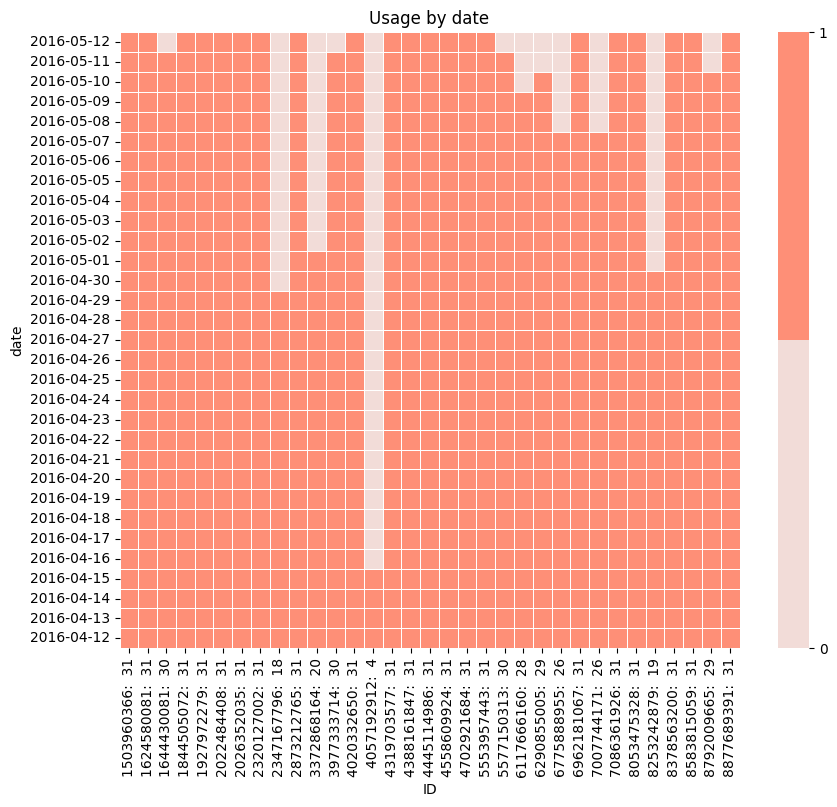

In [10]:
# Dates of usage for each id
query = """
SELECT 
    id as ID
    ,ActivityDay as date
FROM
    dailyCalories
ORDER BY
    2 DESC
"""

df = pd.read_sql_query(query, engine)

# Get matrix of 1s and 0s for the usage of the device by user id
dates_used = df.pivot_table(
    index = 'date',
    columns='ID',
    aggfunc=len,
    fill_value = 0
)

dates_used = dates_used.sort_index(ascending=False)

# Adding total days used for the x-label
sum_usage = dates_used.sum()
x_labels = [f'{col}:  {sum_usage[col]}' for col in dates_used.columns]


# Heatmap - usage by date
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data=dates_used, linewidths=.5, cbar=True, cmap=binary_palette, cbar_kws={'ticks': [0, 1]})
plt.title("Usage by date")
ax.set_xticklabels(x_labels)

plt.show()

Most users used their devices most days. However, there were users who used it less than 20 days and even one who used it only 4 days. For every user, the usage was continuous — once a user didn't use their device, they stopped using it instead of having gaps in the usage throughout the month.

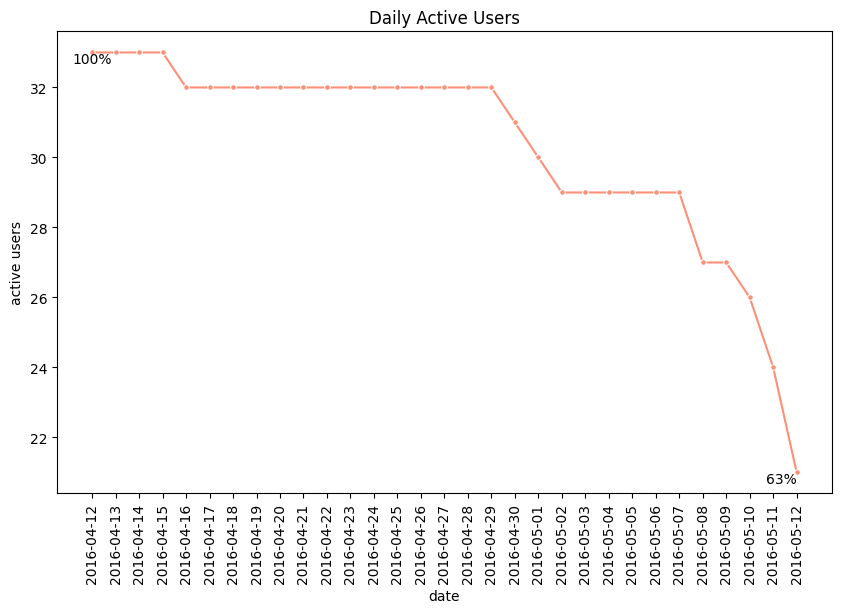

In [11]:
# Number and percentage of active users on each date
query = """
WITH total_users AS (
SELECT 
    COUNT(DISTINCT Id) AS total_users
FROM dailyCalories
)

SELECT
    activityDay AS date
    ,COUNT(DISTINCT Id) AS id_cnt
    ,COUNT(DISTINCT Id) * 100 / total_users AS pct
FROM dailyCalories, total_users
GROUP BY 1
ORDER BY 1
"""

df = pd.read_sql_query(query, engine)
df


# Linechart - number of daily active users
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=df, x='date', y='id_cnt', marker='o', markersize=4, color=bbcolor)

# Show only the first and last percentage labels
first_idx = 0
last_idx = len(df) - 1

# Add percentage label for the first point
plt.text(df['date'][first_idx], df['id_cnt'][first_idx], f'{df["pct"][first_idx]}%', 
         ha='center', va='top')

# Add percentage label for the last point
plt.text(df['date'][last_idx], df['id_cnt'][last_idx], f'{df["pct"][last_idx]}%', 
         ha='right', va='top')
    
ax.set_title('Daily Active Users')
ax.set_ylabel('active users')

plt.xticks(rotation=90, fontsize=10)

plt.show()

By the end of the period, only 63% of the users were still using their devices.

⤴️ [Back to table of contents](#back)

## Calories Function <a id="calories"></a>

In this section we will explore the trends related to the calories burned, based on the data offered by the devices. 

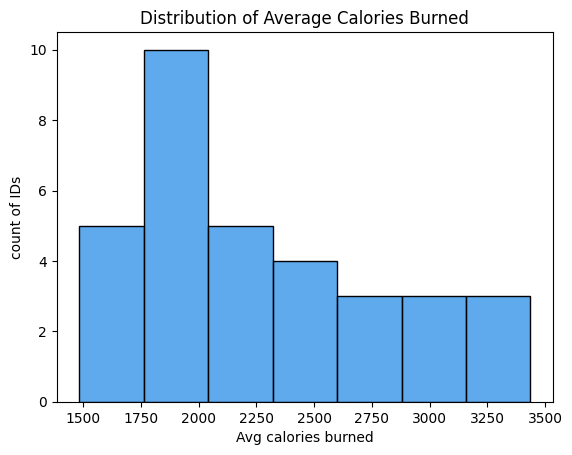

In [12]:
# Average calories burned by user id
query = """
SELECT
    Id
    ,AVG(calories) as calories_avg
FROM dailyActivity
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df


# Histogram - calories burned
ax = sns.histplot(data=df['calories_avg'], color=bbcalories)

ax.set_title('Distribution of Average Calories Burned')
ax.set_xlabel('Avg calories burned')
ax.set_ylabel('count of IDs')

plt.show()

In [13]:
# Min and max values of average calories burned by user
query = """
WITH average_calories AS (
SELECT
    Id
    ,AVG(calories) as calories_avg
FROM dailyActivity
GROUP BY
    1
)

SELECT
    ROUND(MIN(calories_avg), 2) AS min_avg
    ,ROUND(MAX(calories_avg), 2) AS max_avg
FROM
    average_calories
"""

df = pd.read_sql_query(query, engine)
df

,min_avg,max_avg
0,1483.35,3436.58


The average calories burned range roughly between 1500 and 3500 per user, with around 30 percent of the users burning between 1750 and 2000 calories. Let's examine the average calories burned per day of the week.

In [14]:
# Average calories burned by day of the week
query = """
WITH avg_calories_user_dow AS (
SELECT
    Id
    ,strftime('%w', activityDay) as dow
    ,AVG(calories) AS calories_avg
FROM dailyCalories
GROUP BY
    1, 2
)

SELECT
    dow
    ,AVG(calories_avg) AS calories_avg
FROM avg_calories_user_dow
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df

,dow,calories_avg
0,0,2252.020833
1,1,2311.901042
2,2,2340.690404
3,3,2295.897475
4,4,2195.264141
5,5,2298.984848
6,6,2348.453125


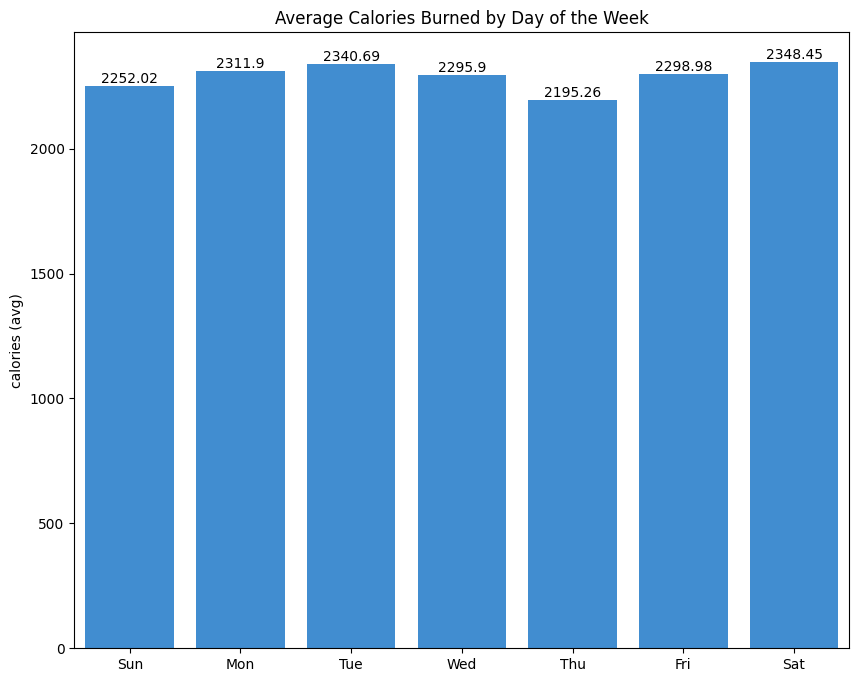

In [15]:
# Barchart - average calories burned by dow, aggregated by user
plt.figure(figsize=(10,8))

ax = sns.barplot(data=df, x='dow', y='calories_avg', color=bbcalories)

ax.set_title('Average Calories Burned by Day of the Week')
ax.set_xlabel('')
ax.set_ylabel('calories (avg)')

ax.set_xticks(range(7))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

ax.bar_label(ax.containers[0], fontsize=10);

plt.show()

The average for each day of the week are similar, with Thursday presenting the lower average, and Tuesday and Saturday the highest. However, the average for each day of the week is above 2000, which is around the average of calories burned for moderately active people based on <a href='https://health.clevelandclinic.org/calories-burned-in-a-day]'>Clinic of Cleveland</a>.

Let's look at the distribution of the calories burned per day of the week.

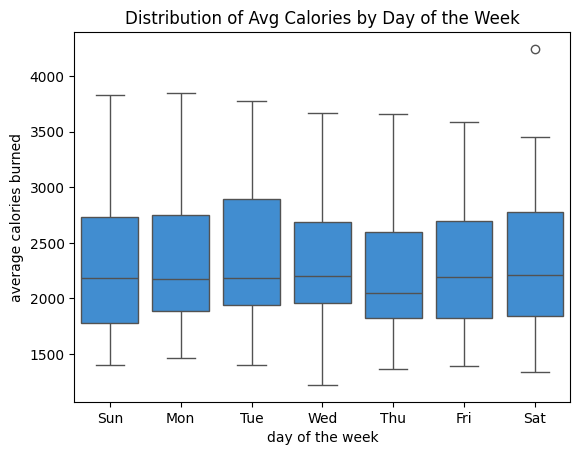

In [16]:
# Average calories burned by dow, disaggregated
query = """
SELECT
    Id
    ,strftime('%w', activityDay) as dow
    ,AVG(calories) AS calories_avg
FROM dailyCalories
GROUP BY
    1, 2

"""

df = pd.read_sql_query(query, engine)


# Boxplot - average calories burned by day of the week
ax = sns.boxplot(data=df, x='dow', y='calories_avg', color=bbcalories)

ax.set_title('Distribution of Avg Calories by Day of the Week')
ax.set_xlabel('day of the week')
ax.set_ylabel('average calories burned')

ax.set_xticks(range(7))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

plt.show()

In addition to having the highest averages, Tuesday and Saturday are the days with higher variability, the latter presenting an outlier that might be dragging the mean up. 

Let's also look at the average calories burned by time of the day.

In [17]:
# Average calories burned by hour, aggregated by user
query = """
WITH avg_calories_user_hour AS (
SELECT
    Id
    ,strftime('%H', ActivityHour) as hour
    ,AVG(calories) AS calories_avg_hr
FROM hourlyCalories
GROUP BY
    1, 2
),

general_avg AS (
SELECT
    Id
    ,AVG(calories) AS calories_avg_user
FROM hourlyCalories
GROUP BY 1
)


SELECT
    hour
    ,AVG(calories_avg_hr) AS calories_avg
    ,CASE WHEN AVG(calories_avg_hr) > (SELECT AVG(calories_avg_user) FROM general_avg) THEN 1 ELSE 0 END AS high_calories
FROM avg_calories_user_hour
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df


,hour,calories_avg,high_calories
0,00,71.495567,0
1,01,69.877634,0
2,02,68.952733,0
3,03,67.536345,0
4,04,68.073958,0
5,05,80.455158,0
6,06,86.018677,0
7,07,94.994020,0
8,08,104.735445,1
9,09,105.965819,1


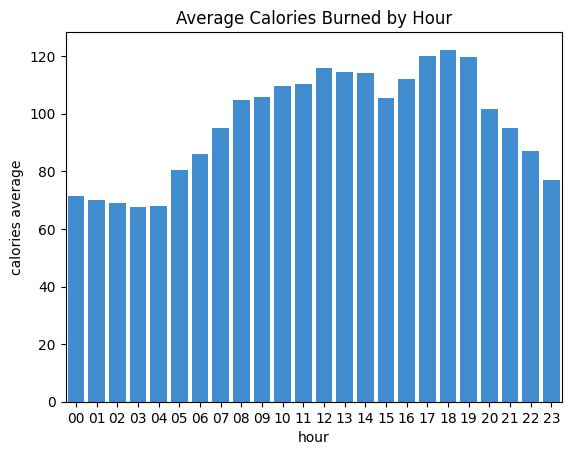

In [18]:
# Histogram of the average calories burned by hour
ax = sns.barplot(df, x='hour', y='calories_avg', color=bbcalories)

ax.set_title('Average Calories Burned by Hour')
ax.set_ylabel('calories average')

plt.show()

This chart shows that the highest number of calories burned occurs between 12:00–15:00 and 17:00–20:00, which may indicate increased activity during typical lunch breaks and after work hours. However, since we lack demographic data, we cannot assume that all users have similar schedules.

⤴️ [Back to table of contents](#back)

# Steps Function <a id="steps"></a>

In this section we will delve into the steps taken by the users and explore its relationship with the calories burned. 

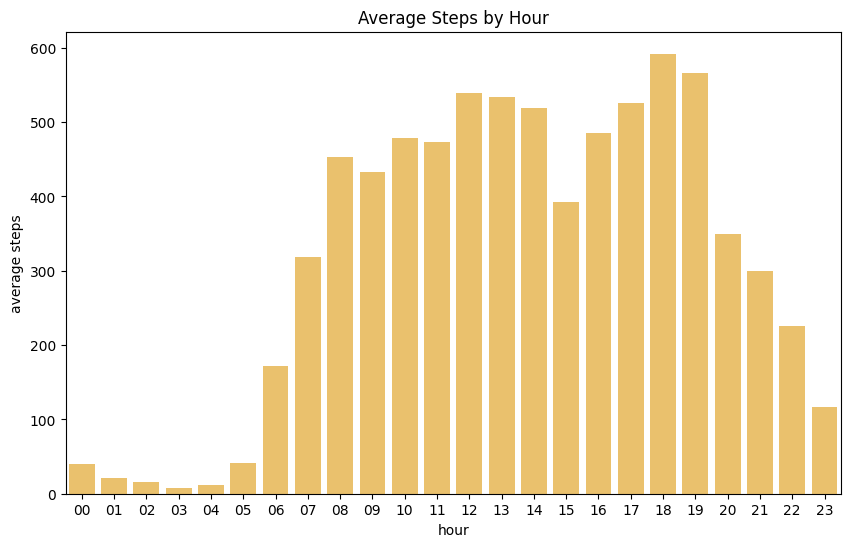

In [19]:
# Average number of steps taken by hour, aggregated
query = """
WITH avg_steps_user_hour AS (
SELECT
    Id
    ,strftime('%H', activityHour) as hour
    ,AVG(stepTotal) AS steps_avg
FROM hourlySteps
GROUP BY
    1, 2
)

SELECT
    hour
    ,AVG(steps_avg) AS steps_avg
FROM avg_steps_user_hour
GROUP BY
    1
"""

df = pd.read_sql_query(query, engine)
df

plt.figure(figsize=(10,6))

ax = sns.barplot(data=df, x='hour', y='steps_avg', color=bbsteps)

ax.set_title('Average Steps by Hour')
ax.set_ylabel('average steps')
plt.show()

This bar chart illustrates that the lowest number of steps occurs when people are typically sleeping. Similar to the calories burned, most steps are taken between 12:00–15:00 and 17:00–20:00. This may suggest that activities like walking and running are responsible for the increase in calories burned during these times, rather than other types of physical activities that tend to be more static (e.g., weightlifting).

/var/folders/mg/hptp2zld5cl6kjcrwfys_p5h0000gn/T/ipykernel_27693/1421985032.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10)


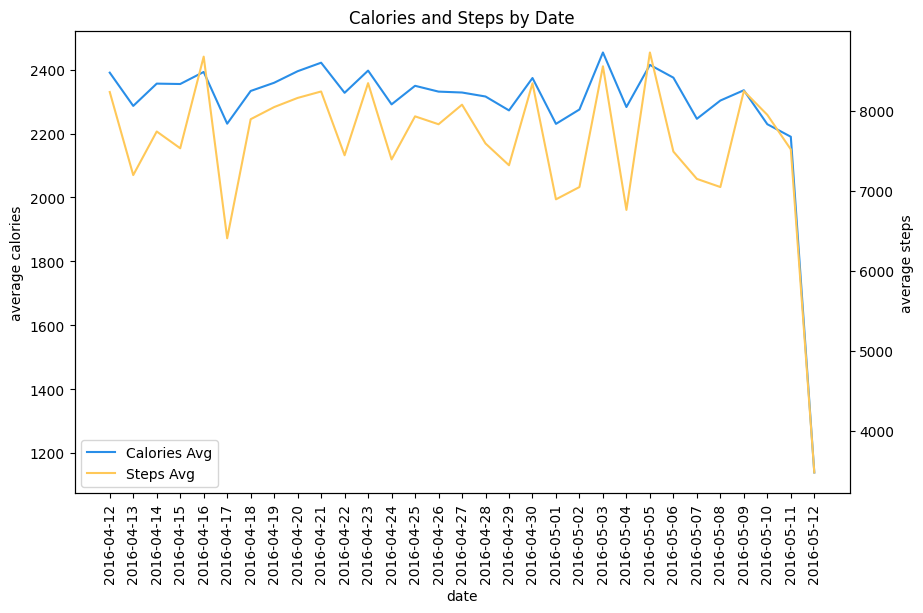

In [20]:
# Average calories burned and steps taken by date, aggregated
query = """
SELECT
    c.activityDay AS date
    ,AVG(calories) AS calories_avg
    ,AVG(stepTotal) AS steps_avg
FROM
    dailyCalories c
JOIN
    dailySteps s ON c.Id = s.Id AND c.activityDay = s.activityDay
GROUP BY 1
"""

df = pd.read_sql_query(query, engine)


# Linechart - calories and steps average
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df, x='date', y='calories_avg', ax=ax1, label='Calories Avg', color=bbcalories,legend=False)

ax2 = ax1.twinx()
sns.lineplot(data=df, x='date', y='steps_avg', ax=ax2, label='Steps Avg', color=bbsteps, legend=False)

ax1.set_title('Calories and Steps by Date')
ax1.set_ylabel('average calories')
ax2.set_ylabel('average steps')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=10)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='lower left')

plt.show()

We observe a pattern where increases and decreases in steps appear to relate with corresponding changes in calories burned. Notably, there is a sharp decline in both steps and calories burned on the final date, which we will explore further later.

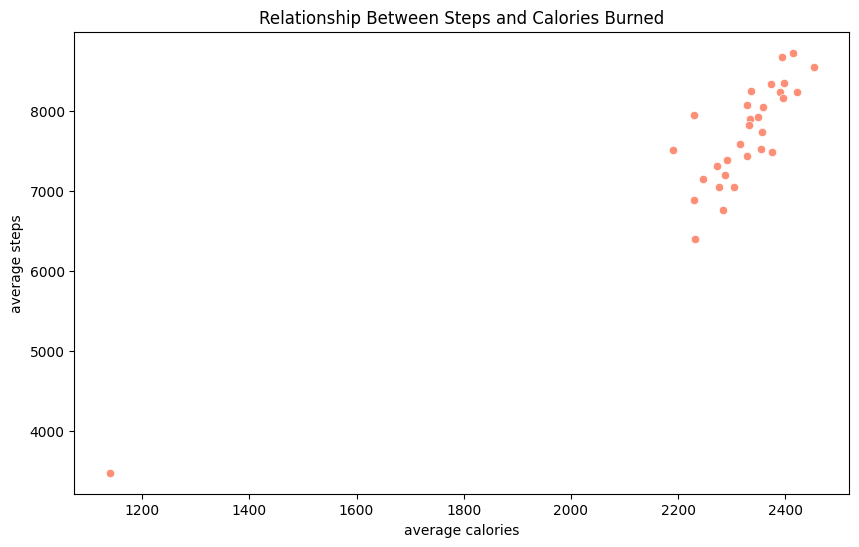

In [21]:
# Average calories and steps by date, aggregated
query = """
SELECT
    c.activityDay AS date
    ,AVG(calories) AS calories_avg
    ,AVG(stepTotal) AS steps_avg
FROM
    dailyCalories c
JOIN
    dailySteps s ON c.Id = s.Id AND c.activityDay = s.activityDay
GROUP BY 1
"""

df = pd.read_sql_query(query, engine)

# Scatterplot - relationship between steps and calories burned
plt.figure(figsize=(10, 6))

ax =sns.scatterplot(data=df, x='calories_avg', y='steps_avg', color=bbcolor)
ax.set_title('Relationship Between Steps and Calories Burned')
ax.set_ylabel('average steps')
ax.set_xlabel('average calories')

plt.show()

There is a clear positive relationship between steps and calories.

In [22]:
# Looking into decline in last date (2016-05-12)
query = """
SELECT
    *
FROM dailyCalories c
JOIN dailySteps s ON c.Id = s.Id AND c.activityDay = s.activityDay
WHERE c.activityDay = '2016-05-12'
"""

df = pd.read_sql_query(query, engine)
df

,Id,ActivityDay,Calories,Id,ActivityDay,StepTotal
0,1503960366,2016-05-12,0,1503960366,2016-05-12,0
1,1624580081,2016-05-12,1002,1624580081,2016-05-12,2971
2,1844505072,2016-05-12,665,1844505072,2016-05-12,0
3,1927972279,2016-05-12,1383,1927972279,2016-05-12,0
4,2022484408,2016-05-12,1853,2022484408,2016-05-12,9117
5,2026352035,2016-05-12,1364,2026352035,2016-05-12,8891
6,2320127002,2016-05-12,1125,2320127002,2016-05-12,2661
7,2873212765,2016-05-12,1431,2873212765,2016-05-12,7566
8,4020332650,2016-05-12,1120,4020332650,2016-05-12,590
9,4319703577,2016-05-12,257,4319703577,2016-05-12,17


Some users present 0 or very few steps and calories burned for this date, which might be dragging the average down and be the reason for the outlier. Let's explore other cases where users got a recording of 0 steps.

In [23]:
# Number of entries with no steps registered
query = """
SELECT
    COUNT(*) AS instances
FROM dailyCalories c
JOIN dailySteps s ON c.Id = s.Id AND c.activityDay = s.activityDay
WHERE steptotal = 0
"""

df = pd.read_sql_query(query, engine)
df

,instances
0,77


In [24]:
# Distinct users that didn't register steps at least on one date
query = """
SELECT
    COUNT(DISTINCT s.Id) AS users
FROM dailyCalories c
JOIN dailySteps s ON c.Id = s.Id AND c.activityDay = s.activityDay
WHERE steptotal = 0
"""

df = pd.read_sql_query(query, engine)
df

,users
0,15


In [25]:
# instances where calories burned were 0
query = """
SELECT
    c.ActivityDay AS date
    ,c.Id AS id
    ,calories
    ,stepTotal
FROM dailyCalories c
JOIN dailySteps s ON c.Id = s.Id AND c.activityDay = s.activityDay
WHERE Calories = 0
ORDER BY c.activityDay
"""

df = pd.read_sql_query(query, engine)
df

,date,id,Calories,StepTotal
0,2016-04-30,8253242879,0,0
1,2016-05-10,6290855005,0,0
2,2016-05-12,1503960366,0,0
3,2016-05-12,8583815059,0,0


In general, there appears to be a positive correlation between the number of steps and calories burned, which aligns with the expectation that physical activity drives calorie expenditure. However, several instances with no registered steps and zero calories burned could skew the analysis, especially given the low number of observations available.

⤴️ [Back to table of contents](#back)

## Sleep Function <a id="sleep"></a>

Here we will take a look at the sleep and whether or not it was affected by the number of calories burned the day before.

In [26]:
# Number of sleep entries by user
query = """
SELECT
    Id
    ,COUNT(*) AS sleep_reg
FROM 
    sleepDay
GROUP BY 1
ORDER BY 2 desc
"""

df = pd.read_sql_query(query, engine)
df

,Id,sleep_reg
0,8378563200,32
1,6962181067,31
2,5553957443,31
3,4702921684,28
4,4445114986,28
5,3977333714,28
6,2026352035,28
7,5577150313,26
8,4319703577,26
9,1503960366,25


Most of the users didn't register their sleep data for the whole period, many of them having data of less than 70% of the dates. Even though the number of participants is already low, we will only consider those that have sleep data for more than 70% of the dates.

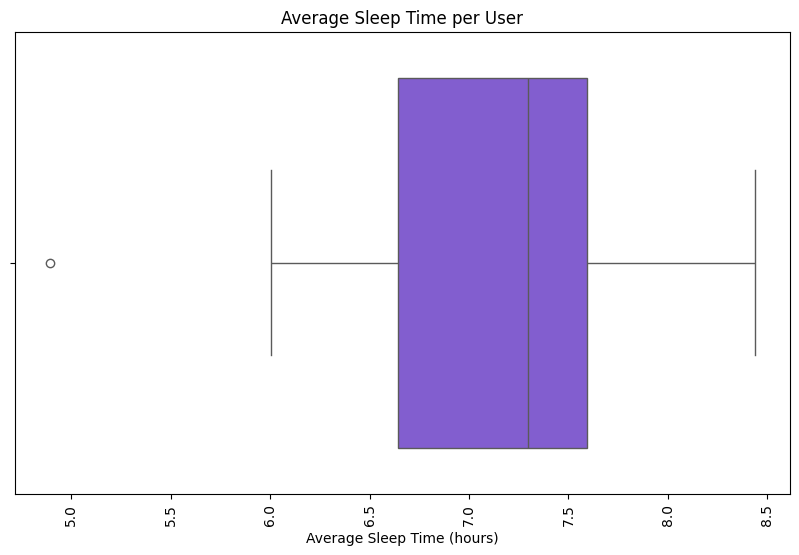

In [27]:
# Average sleep time per user (for users with data in 70%+ of the days)
query = """
SELECT
    Id
    ,AVG(totalMinutesAsleep)/60 AS avg_sleep_time
FROM
    sleepDay
WHERE Id IN (
    SELECT
        Id
    FROM 
        sleepDay
    GROUP BY Id
    HAVING COUNT(*) > (32 * 0.7) --70% of the total number of days
)
GROUP BY Id
ORDER BY 2 DESC
"""


df = pd.read_sql_query(query, engine)
df

# Bocplot - distributions of avg sleep time
sorted_df = df.sort_values(by='avg_sleep_time', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='avg_sleep_time', color=bbsleep)

ax.set_title('Average Sleep Time per User')
#ax.set_xlabel('')
ax.set_xlabel('Average Sleep Time (hours)')
plt.xticks(rotation=90) 

plt.show()

On average, the users have a sleep length of almost 7.5 hours, with most of the users sleeping between around 6.6 and 7.6 hours.

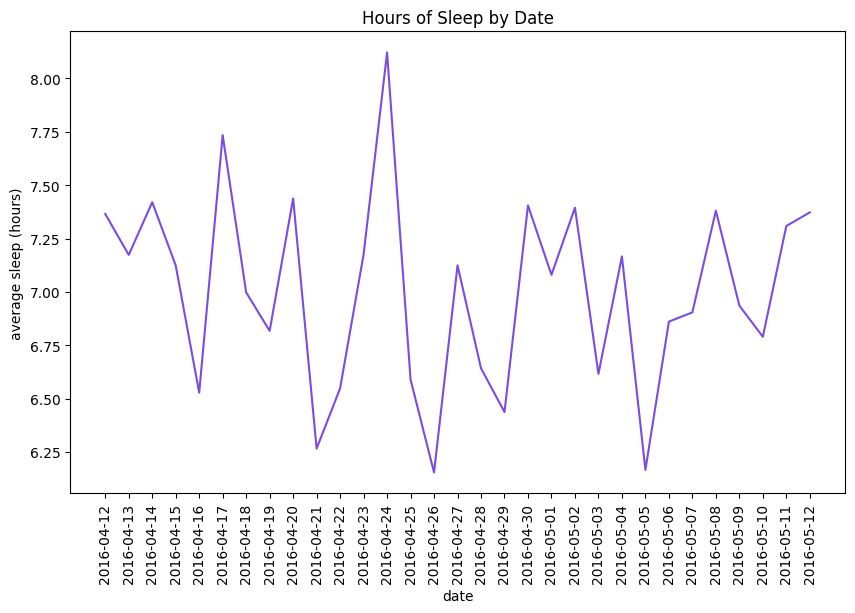

In [28]:
# Hours of sleep per day
query = """
SELECT
    DATE(SleepDay) AS date
    ,AVG(TotalMinutesAsleep)/60 AS sleep_avg
FROM
    sleepDay
GROUP BY 1
"""


df = pd.read_sql_query(query, engine)
df

plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df, x='date', y='sleep_avg', color=bbsleep)

plt.title('Hours of Sleep by Date')
ax.set_ylabel('average sleep (hours)')

plt.xticks(rotation=90, fontsize=10)

plt.show()

The chart doesn't show any clear pattern in sleep hours throught the month. Let's compare it to the calories burned and then look at it by day of the week.

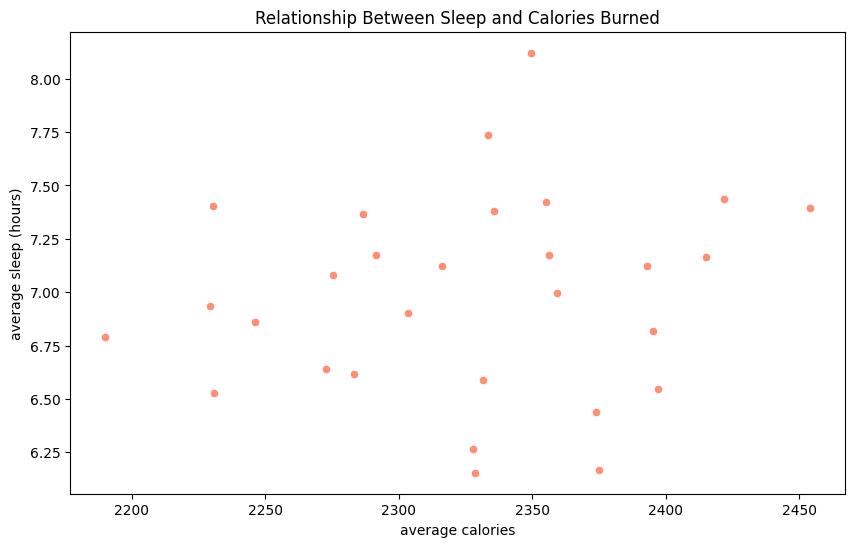

In [29]:
# Sleep and calories burned by date
query = """
WITH calories_sleep AS (
SELECT
    DATE(SleepDay) AS date
    ,AVG(TotalMinutesAsleep)/60 AS sleep_avg
    ,AVG(calories) AS calories_avg
FROM
    sleepDay s
JOIN
    dailyCalories c ON DATE(s.sleepDay) = c.activityDay
WHERE activityDay < '2016-05-12'
GROUP BY 1
)

SELECT
    cs.date,
    cs.calories_avg,
    cs2.sleep_avg -- Joining on the next day for sleep average
FROM 
    calories_sleep cs
LEFT JOIN 
    calories_sleep cs2 ON cs.date = DATE(cs2.date, '+1 day')
"""

df = pd.read_sql_query(query, engine)
df


# Scatterplot - relationship between sleep hours and calories burned the day before
plt.figure(figsize=(10, 6))

ax =sns.scatterplot(data=df, x='calories_avg', y='sleep_avg', color=bbcolor)
ax.set_title('Relationship Between Sleep and Calories Burned')
ax.set_ylabel('average sleep (hours)')
ax.set_xlabel('average calories')

plt.show()


There is no clear relationsship between the number of calories burned and the length of sleep for the day after. 

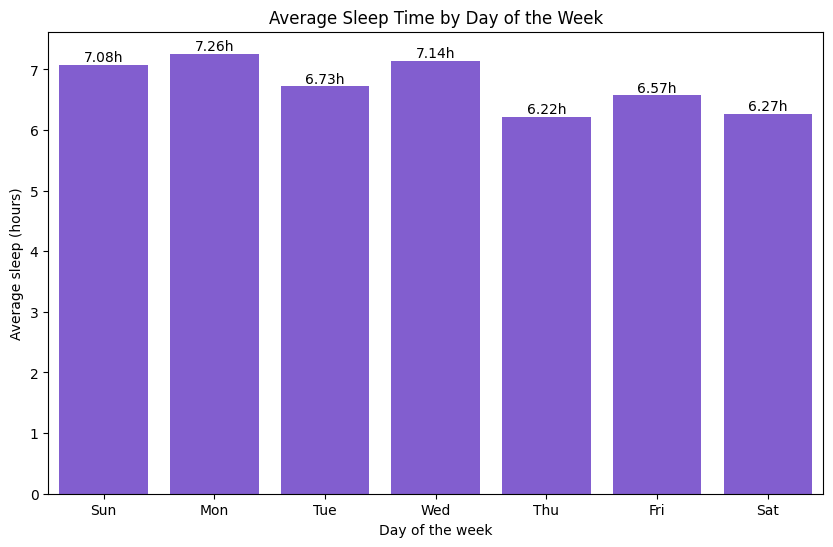

In [30]:
# Sleep by day of the week 
query = """
WITH avg_sleep_user_dow AS (
SELECT
    Id
    ,strftime('%w', DATE(sleepDay)) as dow
    ,AVG(TotalMinutesAsleep)/60 AS sleep_avg
FROM 
    sleepDay
GROUP BY 1, 2
)


SELECT
    dow
    ,AVG(sleep_avg) AS sleep_avg
FROM
    avg_sleep_user_dow
GROUP BY 
    1
"""

df = pd.read_sql_query(query, engine)
df

# BArchart - Average sleep hours by dow
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df, x='dow', y='sleep_avg', color=bbsleep)

plt.title('Average Sleep Time by Day of the Week')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Average sleep (hours)')

ax.set_xticks(range(7))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])

ax.bar_label(ax.containers[0], fmt='%.2fh', fontsize=10)


plt.show()

⤴️ [Back to table of contents](#back)

## Intensities Function <a id="intensities"></a>

Lastly, we will explore the intensities to get a better inderstanding of the type of users in terms how sedentary or active they are. 

In [31]:
# Total time os intensities (usage) registered by user
query = """
WITH total_activity_time AS (
SELECT 
    Id
    ,activityDay
    ,(SedentaryMinutes + LightlyActiveMinutes + FairlyActiveMinutes + VeryActiveMinutes) / 60 AS total
FROM dailyIntensities
GROUP BY 1, 2
)

SELECT
    Id
    ,AVG(total) device_time_avg
FROM 
    total_activity_time
GROUP BY
    1
ORDER BY
    2 DESC
"""

df = pd.read_sql_query(query, engine)
df

,Id,device_time_avg
0,8253242879,23.947368
1,8583815059,23.935484
2,6290855005,23.758621
3,2873212765,23.741935
4,2022484408,23.741935
5,1624580081,23.741935
6,8877689391,23.709677
7,2320127002,23.645161
8,3372868164,23.600000
9,4558609924,23.225806


Based on the average activity time of the users, it appears that most do not wear their devices consistently throughout the day. Those who wear their devices for 23 hours or more likely only take them off for charging. We will examine the average times for each activity level, but it's important to note that because users do not wear their devices all the time, we cannot accurately estimate their true levels of activity.

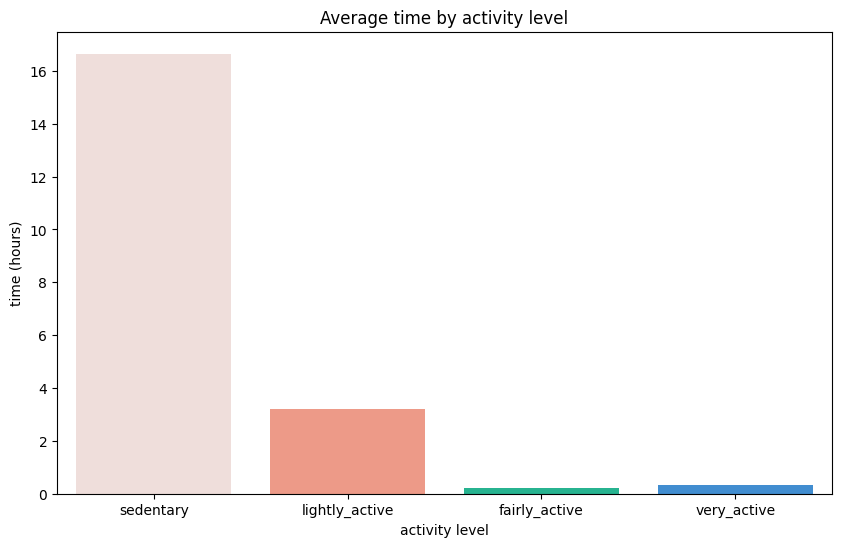

In [32]:
# Average time in each activity level, aggregated
query = """
WITH avg_activity_time AS (
SELECT 
    Id
    ,AVG(SedentaryMinutes) AS sedentary
    ,AVG(LightlyActiveMinutes) AS lightly_active
    ,AVG(FairlyActiveMinutes) AS faily_active
    ,AVG(VeryActiveMinutes) AS very_active
FROM dailyIntensities
GROUP BY 1
)

SELECT
    AVG(sedentary)/60 AS sedentary
    ,AVG(lightly_active)/60 AS lightly_active
    ,AVG(faily_active)/60 AS fairly_active
    ,AVG(very_active)/60 AS very_active
FROM 
    avg_activity_time
"""

df = pd.read_sql_query(query, engine)
df_melted = df.melt(var_name='activity_level', value_name='time_hours')
df


# Barchart - average time by activity level
colors = ['#f2dcd8', '#fe8f77', '#10ca9c', '#298ee8'] 

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_melted, x='activity_level', y='time_hours', hue='activity_level', palette=colors)

plt.title('Average time by activity level')
ax.set_xlabel('activity level')
ax.set_ylabel('time (hours)')

plt.show()

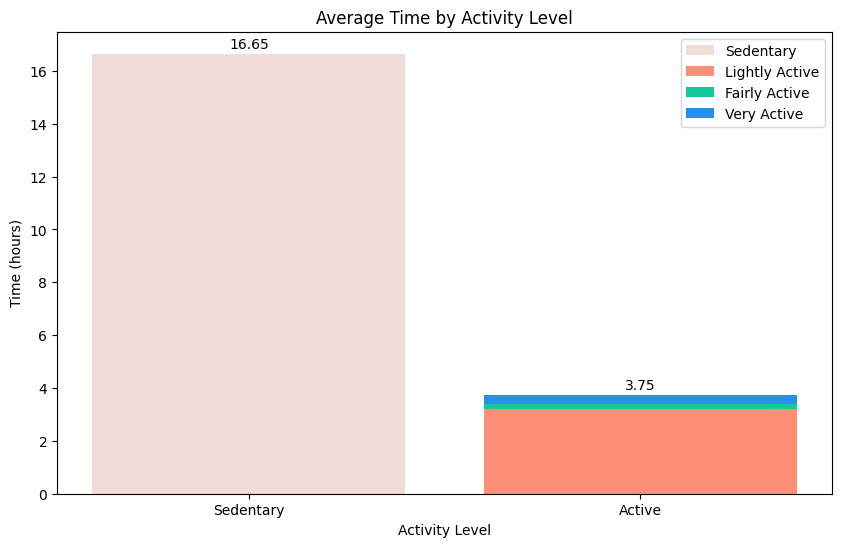

In [33]:
# Prepare data for stacking bar
labels = ['Sedentary', 'Active']
sedentary_time = df['sedentary'].values
lightly_active_time = df['lightly_active'].values
fairly_active_time = df['fairly_active'].values
very_active_time = df['very_active'].values

total_active_time = lightly_active_time + fairly_active_time + very_active_time

# Define colors
sedentary_color = '#f2dcd8'
lightly_active_color = '#fe8f77'
fairly_active_color = '#10ca9c'
very_active_color = '#298ee8' 

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(labels[0], sedentary_time, color=sedentary_color, label='Sedentary')
ax.bar(labels[1], lightly_active_time, color=lightly_active_color, label='Lightly Active')
ax.bar(labels[1], fairly_active_time, bottom=lightly_active_time, color=fairly_active_color, label='Fairly Active')
ax.bar(labels[1], very_active_time, bottom=lightly_active_time + fairly_active_time, color=very_active_color, label='Very Active')

ax.text(labels[0], sedentary_time + 0.1, f'{sedentary_time[0]:.2f}', ha='center', va='bottom', fontsize=10)
ax.text(labels[1], total_active_time + 0.1, f'{total_active_time[0]:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_title('Average Time by Activity Level')
ax.set_ylabel('Time (hours)')
ax.set_xlabel('Activity Level')

ax.legend()

plt.show()

On average, users have more than 16 sedentary hours, and less than 4 active hours (ranging from low to high activity).

⤴️ [Back to table of contents](#back)

## Conclusions <a id="conclusion"></a>

The analysis of smart device usage data reveals some important insights into user behavior and opportunities for growth. Key findings include:

* Caloric Burn Patterns: The highest calorie burn occurs during lunchtime and early evening hours, indicating higher physical activity during these periods. However, due to the absence of demographic data, we cannot make conclusive assumptions about user schedules.

* Step Count Correlation: There is a positive relationship between steps taken and calories burned, suggesting that encouraging more physical activity could be an effective strategy for boosting user engagement. Instances with zero steps and calories could distort overall averages and may indicate that further investigation is required.

* Sleep Data Limitations: Inconsistent sleep data collection hampers the ability to understand the relationship between sleep and activity levels. Users sleep an average of 7.5 hours, but no discernible link with calories burned was found.

* Engagement Insights: Users tend to have more sedentary hours than active hours, which presents an opportunity to develop strategies aimed at increasing daily activity and consistent device usage.

* Device usage: While many users engage with their devices regularly, the decline in active users and inconsistent usage patterns suggest room for improvement in user retention and engagement strategies. It might also indicate that there might be occasions in which the users prefer not to wear their devices.


### Recommendations
* Targeted Campaigns During High Activity Times: Launch campaigns during the periods when users are most active (e.g., 12:00–15:00 and 17:00–20:00), as this aligns with their observed engagement patterns. Ads could promote health and fitness tips, motivational content, or special offers related to fitness products.

*   Highlighting Bellabeat's Stylish Design: Since some users may avoid wearing their devices all day due to aesthetic concerns, marketing efforts should emphasize Bellabeat’s elegant and discreet designs that suit various lifestyles and occasions, appealing to users who value both style and functionality.
  
*   Leverage Social Proof to Encourage Consistent Usage: Use testimonials or influencer partnerships to demonstrate the benefits of regular device use, promoting the idea that users who consistently wear their devices achieve better health outcomes.
  
* Expand Data Analysis for Greater Insights: The current dataset, which is small, outdated, and sourced from a different company, limits the accuracy and relevance of the findings. Additionally, the absence of demographic data restricts deeper insights into user behaviors and preferences. Bellabeat should consider analyzing its own data if available, or sourcing more recent and comprehensive datasets that include demographic information, lifestyle factors, and other relevant metrics. This will allow for a more precise understanding of user needs and preferences.

Expanding the analysis could also inform product and feature development. Understanding user preferences might guide the inclusion of features such as activity challenges, rewards for consistent usage, or reminders to stay active. These features can be promoted in marketing efforts to enhance user engagement.

⤴️ [Back to table of contents](#back)